In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

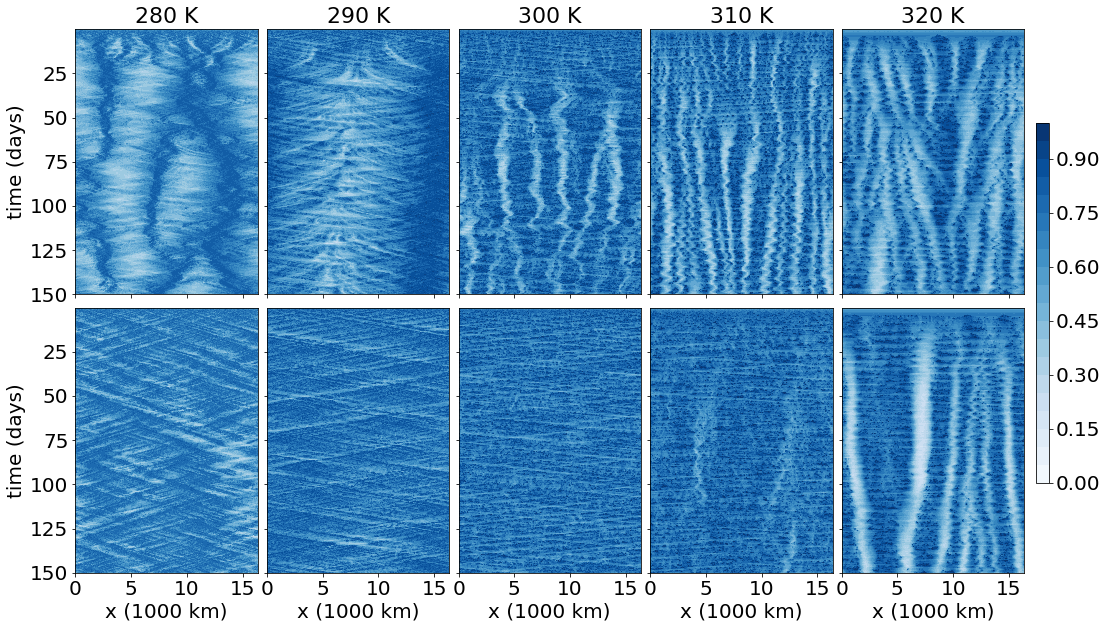

In [4]:
####### Figure 1a-j ################
# get the 2D simulations' PW plots
sst_list = np.arange(280,330,10)
pw_control = []
pw_homorad = []

for i, sst in enumerate(sst_list):
    fn2d = '/glade/scratch/linyao/SAMOUTPUT/csa2dLD'+str(sst)+'Kfine/dx2km8192x1xfiner/exe.sam/OUT_2D/CSALD'+str(sst)+'Kfine_dx2km8192x1x128x3600_2dfile.nc'
    ds = xr.open_dataset(fn2d)
    tmp = ds['PW'][:, 0::8] / ds['SWVP'][:, 0::8]
    pw_control.append(tmp)
    del ds 
    fn2d = '/glade/scratch/linyao/SAMOUTPUT/csa2dLDhomoRAD/CSALD'+str(sst)+'KfineHomoRCL_2dfile.nc'
    ds = xr.open_dataset(fn2d)
    tmp = ds['PW'][:, 0::8] / ds['SWVP'][:, 0::8]
    pw_homorad.append(tmp)
    
    
t = ds['time']
x = ds['x'][0::8] / 1e6   
del ds

# draw the plots for control simulations
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(17,10))
gs = fig.add_gridspec(2, 5, hspace=0.05, wspace=0.05)
axs = gs.subplots()
plt.rcParams.update({'font.size': 20})

for i, sst in enumerate(sst_list):
    plt.rcParams.update({'font.size': 20})

    levels = np.arange(0,1.05,0.05)
    plt.rcParams.update({'font.size': 20})
    im1 = axs[0,i].contourf(x, t, pw_control[i], cmap='Blues', levels=levels)
    axs[0,i].set_title(str(sst)+ ' K', fontsize=22)
    axs[0,i].invert_yaxis()
    
    im2 = axs[1,i].contourf(x, t, pw_homorad[i], cmap='Blues', levels=levels)
    axs[1,i].invert_yaxis()
    plt.rcParams.update({'font.size': 20})
    
for ax in axs.flat:
    ax.set(xlabel='x (1000 km)', ylabel='time (days)')
    ax.set_xticks([0,5,10,15])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.25, 0.01, 0.5])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig('Figure1_CRH.png',dpi=600, bbox_inches='tight')

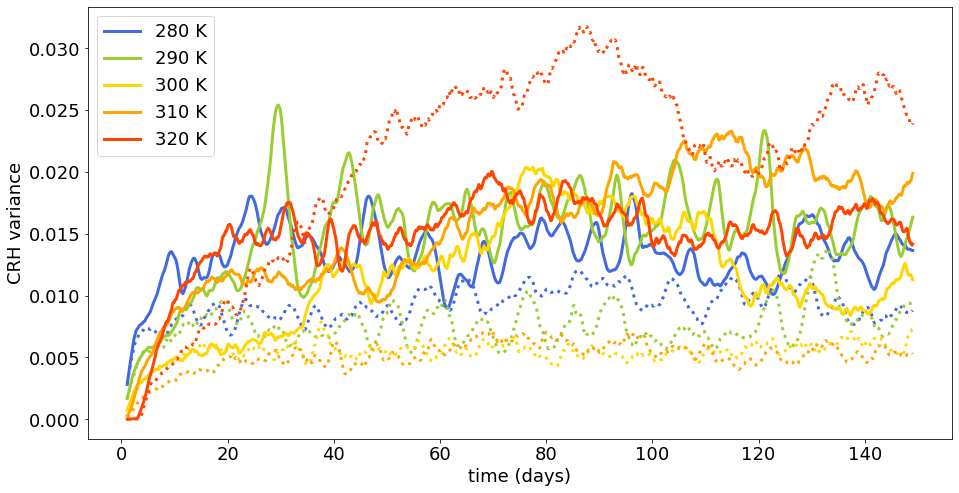

In [3]:
########### Figure 1k ######################
# get PW variance for each climate in the control and mechanism-denial experiments
sst_list = np.arange(280,330,10)
pwvar_control = []
pwvar_homorad = []

for i, sst in enumerate(sst_list):
    fn2d = '/glade/scratch/linyao/SAMOUTPUT/csa2dLD'+str(sst)+'Kfine/dx2km8192x1xfiner/exe.sam/OUT_2D/CSALD'+str(sst)+'Kfine_dx2km8192x1x128x3600_2dfile.nc'
    a = xr.open_dataset(fn2d)['PW']
    b = xr.open_dataset(fn2d)['SWVP']
    PW = a / b
    pwvar_control.append(PW.var(dim=["x"]))
    del PW
    del fn2d
    
    fn2d = '/glade/scratch/linyao/SAMOUTPUT/csa2dLDhomoRAD/CSALD'+str(sst)+'KfineHomoRCL_2dfile.nc'
    a = xr.open_dataset(fn2d)['PW']
    b = xr.open_dataset(fn2d)['SWVP']
    PW = a / b
    pwvar_homorad.append(PW.var(dim=["x"]))
    del PW
    del fn2d
    
linec = ['royalblue','yellowgreen','gold','orange','orangered']
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0.2, 0.2, 0.6, 0.6])
plt.rcParams.update({'font.size': 18})
for i, sst in enumerate(sst_list):   
    y1 = pwvar_control[i].rolling(time=50, center=True).mean().dropna('time')
    y2 = pwvar_homorad[i].rolling(time=50, center=True).mean().dropna('time')
    ax.plot(y1.time, y1, color=linec[i], label=str(sst)+' K', linewidth=3)
    ax.plot(y2.time, y2, color=linec[i], linestyle='dotted', linewidth=3)


ax.set_xlabel('time (days)')
plt.legend()
ax.set_ylabel('CRH variance')
plt.rcParams.update({'font.size': 18})
# plt.savefig('CRH_variance.png', dpi=600, bbox_inches='tight')

In [4]:
######## Figure 2 #################
def get_FMSEbudget_resi(stad, remapflg=False):
    sst_list = np.arange(280,330,10)
    smx_list = [5*8, 11*8, 15*8]  # smooth_x in km
    smt_list = [24, 72, 120, 240]  # smooth_t in hours [1, 3, 5, 10] days
    avlen_list = [5*24, 10*24, 15*24, 20*24, 25*24]
    nsst = len(sst_list)
    nsmx = len(smx_list)
    nsmt = len(smt_list)
    navl = len(avlen_list)

    # for each sst, get the averaged norm budget using different smooth_x, smooth_t and average length. 
    tend0 = np.zeros((nsst, nsmx*nsmt*navl))
    advc0 = np.zeros((nsst, nsmx*nsmt*navl))
    radi0 = np.zeros((nsst, nsmx*nsmt*navl))
    sgs0 = np.zeros((nsst, nsmx*nsmt*navl))

    # seperate the advction term into horizontal, vertical advection and convergence
    advx0 = np.zeros((nsst, nsmx*nsmt*navl))
    advw0 = np.zeros((nsst, nsmx*nsmt*navl))
    suma0 = np.zeros((nsst, nsmx*nsmt*navl))  # advx + advw
    sumd0 = np.zeros((nsst, nsmx*nsmt*navl))  # radi + sgs
    # resi0 = np.zeros((nsst, nsmx*nsmt*navl))  # tend - suma - radi - sgs

    # for each sst, get the mean and std of the averaged norm budget distribution
    tend = np.zeros((nsst, 2))
    advc = np.zeros((nsst, 2))
    radi = np.zeros((nsst, 2))
    sgs = np.zeros((nsst, 2))

    # seperate the advection term
    advx = np.zeros((nsst, 2))
    advw = np.zeros((nsst, 2))
    suma = np.zeros((nsst, 2))
    sumd = np.zeros((nsst, 2))
    # resi = np.zeros((nsst, 2))

    for i,sst in zip(np.arange(nsst), sst_list):
        ip0 = 0

        # calculate averaged T profile
        fn1d = '/glade/scratch/linyao/SAMOUTPUT/csa2dLD'+str(sst)+'Kfine/dx2km8192x1xfiner/exe.sam/OUT_STAT/CSALD'+str(sst)+'Kfine_dx2km8192x1x128x3600_1dfile.nc'
        ds = xr.open_dataset(fn1d)
        Teq = ds['TABS'][100*24:150*24,:].mean('time')

        # find the index of Tropopause
        itrop = Teq.argmin(dim="z").values + 1

        for j,smx in zip(np.arange(nsmx), smx_list):
            for k,smt in zip(np.arange(nsmt), smt_list):
                fn = '~/CSA_rad/FMSE_budget_rho/FMSE_budget_1rho_sst'+str(sst)+'K_sgs_control_sx'+str(smx)+'km_st'+str(int(smt/24))+'d.nc'  # run CSA_budget.py
                ds = xr.open_dataset(fn)
                local_var = ds['local_var']
                local_tend = ds['local_tend']
                local_radi = ds['local_radi']
                local_sgs = ds['local_sgs']
                local_advc = ds['local_advc']

                # load seperated advection terms
                fns1 = '~/CSA_rad/FMSE_budget_rho/FMSE_budget_1rho_local_advx_sst'+str(sst)+'K_sgs_control_sx'+str(smx)+'km_st'+str(int(smt/24))+'d.nc'  # run CSA_budget_advx.py
                dss1 = xr.open_dataset(fns1)
                local_advx = dss1['local_advx']

                z = ds['z']
                t = ds['time']

                dz = z[1:].values - z[0:-1].values
                int_tend = np.sum(local_tend[:,:itrop] * dz[None,:itrop], axis=1)
                int_var = np.sum(local_var[:,:itrop] * dz[None,:itrop], axis=1)
                int_radi = np.sum(local_radi[:,:itrop] * dz[None,:itrop], axis=1)
                int_sgs = np.sum(local_sgs[:,:itrop] * dz[None,:itrop], axis=1)
                int_advc = np.sum(local_advc[:,:itrop] * dz[None,:itrop], axis=1)
                int_advx = np.sum(local_advx[:,:itrop] * dz[None,:itrop], axis=1)

                tend1 = int_tend / int_var * 86400
                radi1 = int_radi / int_var * 86400
                sgs1  = int_sgs / int_var * 86400
                advc1 = int_advc / int_var * 86400
                advx1 = int_advx / int_var * 86400

                for n,avl in zip(np.arange(navl), avlen_list):

                    tend0[i,ip0] = np.mean(tend1[stad*24:stad*24+avl*24])
                    advc0[i,ip0] = np.mean(advc1[stad*24:stad*24+avl*24])
                    radi0[i,ip0] = np.mean(radi1[stad*24:stad*24+avl*24])
                    sgs0[i,ip0] = np.mean(sgs1[stad*24:stad*24+avl*24])
                    advx0[i,ip0] = np.mean(advx1[stad*24:stad*24+avl*24])

                    ip0 = ip0 + 1 

        # the mean of the averaged norm budget
        tend[i,0] = np.mean(tend0[i,:])
        # the std of the averaged norm budget
        tend[i,1] = np.std(tend0[i,:])
        # the mean of the averaged norm budget
        advc[i,0] = np.mean(advc0[i,:])
        # the std of the averaged norm budget
        advc[i,1] = np.std(advc0[i,:])
        # the mean of the averaged norm budget
        radi[i,0] = np.mean(radi0[i,:])
        # the std of the averaged norm budget
        radi[i,1] = np.std(radi0[i,:])
        # the mean of the averaged norm budget
        sgs[i,0] = np.mean(sgs0[i,:])
        # the std of the averaged norm budget
        sgs[i,1] = np.std(sgs0[i,:])

        # the mean of the averaged norm budget
        advx[i,0] = np.mean(advx0[i,:])
        # the std of the averaged norm budget
        advx[i,1] = np.std(advx0[i,:])
        
        advw0[i,:] = advc0[i,:] - advx0[i,:] 
        sumd0[i,:] = radi0[i,:] + sgs0[i,:] 

        # the mean of the averaged norm budget
        advw[i,0] = np.mean(advw0[i,:])
        # the std of the averaged norm budget
        advw[i,1] = np.std(advw0[i,:])
        # the mean of the averaged norm budget
        sumd[i,0] = np.mean(sumd0[i,:])
        # the std of the averaged norm budget
        sumd[i,1] = np.std(sumd0[i,:])
    
    FMSEbudget = np.concatenate((tend[:,0,None], advc[:,0,None], advx[:,0,None], advw[:,0,None], sumd[:,0,None], radi[:,0,None], sgs[:,0,None]), axis=1)
    FMSEbudget_std = np.concatenate((tend[:,1,None], advc[:,1,None], advx[:,1,None], advw[:,1,None], sumd[:,1,None], radi[:,1,None], sgs[:,1,None]), axis=1)
    return FMSEbudget, FMSEbudget_std

(-0.8, 0.8)

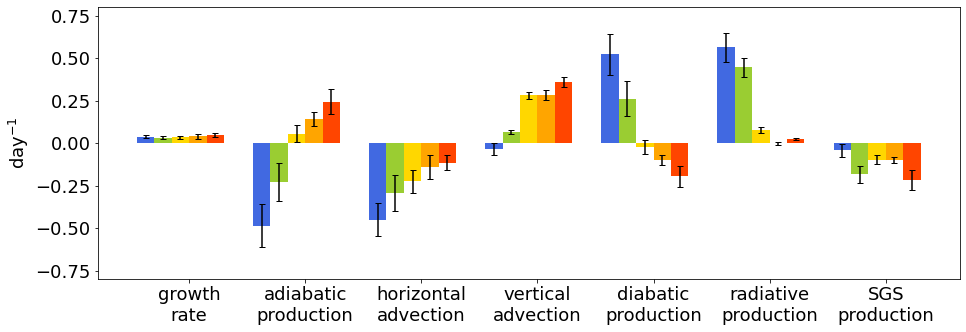

In [6]:
######## Figure 2 #################
FMSEbudget, FMSEbudget_std = get_FMSEbudget_resi(0)
FMSEbudget1, FMSEbudget1_std = get_FMSEbudget_resi(100)

x = ["growth"+"\n"+"rate","adiabatic"+"\n"+"production","horizontal"+"\n"+"advection","vertical"+"\n"+"advection","diabatic"+"\n"+"production","radiative"+"\n"+"production","SGS"+"\n"+"production"]
x_axis = np.arange(len(x))

fig, ax = plt.subplots(1,1,figsize=(7.725*2,5))

plt.rcParams.update({'font.size': 18})
ax.bar(x_axis - 0.375, FMSEbudget[0,:], yerr=FMSEbudget_std[0,:], capsize=3, ecolor='black', width=0.15, label='280 K', color='royalblue')
ax.bar(x_axis - 0.225, FMSEbudget[1,:], yerr=FMSEbudget_std[1,:], capsize=3, ecolor='black', width=0.15, label='290 K', color='yellowgreen')
ax.bar(x_axis - 0.075, FMSEbudget[2,:], yerr=FMSEbudget_std[2,:], capsize=3, ecolor='black', width=0.15, label='300 K', color='gold')
ax.bar(x_axis + 0.075, FMSEbudget[3,:], yerr=FMSEbudget_std[3,:], capsize=3, ecolor='black', width=0.15, label='310 K', color='orange')
ax.bar(x_axis + 0.225, FMSEbudget[4,:], yerr=FMSEbudget_std[4,:], capsize=3, ecolor='black', width=0.15, label='320 K', color='orangered')

ax.set_xticks(x_axis, x)
ax.set_ylabel("day" + r'$^{-1}$')
ax.set_ylim([-0.8,0.8])
# plt.savefig('Figure3aresi.png', dpi=600, bbox_inches='tight')

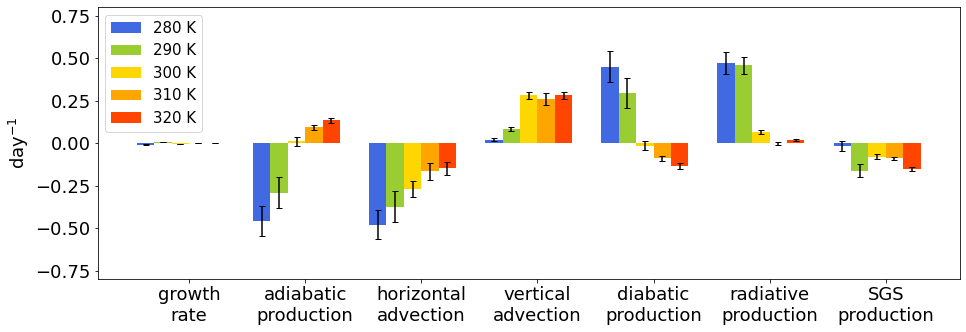

In [7]:
######## Figure 2 #################
x = ["growth"+"\n"+"rate","adiabatic"+"\n"+"production","horizontal"+"\n"+"advection","vertical"+"\n"+"advection","diabatic"+"\n"+"production","radiative"+"\n"+"production","SGS"+"\n"+"production"]
x_axis = np.arange(len(x))
fig, ax = plt.subplots(1,1,figsize=(7.725*2,5))

plt.rcParams.update({'font.size': 18})
ax.bar(x_axis - 0.375, FMSEbudget1[0,:], yerr=FMSEbudget1_std[0,:], capsize=3, ecolor='black', width=0.15, label='280 K', color='royalblue')
ax.bar(x_axis - 0.225, FMSEbudget1[1,:], yerr=FMSEbudget1_std[1,:], capsize=3, ecolor='black', width=0.15, label='290 K', color='yellowgreen')
ax.bar(x_axis - 0.075, FMSEbudget1[2,:], yerr=FMSEbudget1_std[2,:], capsize=3, ecolor='black', width=0.15, label='300 K', color='gold')
ax.bar(x_axis + 0.075, FMSEbudget1[3,:], yerr=FMSEbudget1_std[3,:], capsize=3, ecolor='black', width=0.15, label='310 K', color='orange')
ax.bar(x_axis + 0.225, FMSEbudget1[4,:], yerr=FMSEbudget1_std[4,:], capsize=3, ecolor='black', width=0.15, label='320 K', color='orangered')

ax.set_xticks(x_axis, x)
ax.set_ylim([-0.8,0.8])
ax.set_ylabel("day" + r'$^{-1}$')
ax.legend(fontsize=15, loc='upper left')
# plt.savefig('Figure3bresi.png', dpi=600, bbox_inches='tight')

In [ ]:
######## Figure 3 #################
# calculate smoothed Qrad'
cp = 1004
lv = 2.5104e6
lf = 0.3336e6
Rv = 461
Rd = 287
epsilon = Rd / Rv
eps0 = 29 / 18 -1  # dry_air/H2O - 1
sec_day = 86400  # seconds in a day
smooth_x = 11
smooth_t = 5*24

sst_list = np.arange(310,330,10)
for i, sst in enumerate(sst_list):
    fn3d = '/glade/scratch/linyao/SAMOUTPUT/csa2dLD'+str(sst)+'Kfine/dx2km8192x1xfiner/exe.sam/OUT_3D/CSALD'+str(sst)+'Kfine_dx2km8192x1x128x3600_3dfile.nc'
    ds = xr.open_dataset(fn3d)
    smx_bd = int((smooth_x - 1) / 2)

    Q_RAD = ds['QRAD'][:,:,::4] * cp / sec_day  # change unit to J/kg/s
    Q_RADp = Q_RAD - Q_RAD.mean("x")
    del Q_RAD
    Q_RADp = Q_RADp.rolling(time=smooth_t, min_periods=int(smooth_t/2), center=True).mean().dropna("time")  # smooth in time
    Q_RADp1 = xr.concat([Q_RADp[:,:,-smx_bd::], Q_RADp, Q_RADp[:,:,:smx_bd]], dim="x")
    del Q_RADp
    Q_RADp = Q_RADp1.rolling(x=smooth_x, center=True).mean("x").dropna("x")  # smooth in x 
    del Q_RADp1

    ds00 = xr.Dataset({"Q_RADp":Q_RADp})
    ds00.to_netcdf('/glade/scratch/linyao/SAMOUTPUT/TwoD/Qradp_sst'+str(sst)+'K_sgs_control_sx'+str(int(smooth_x*8))+'km_st'+str(int(smooth_t/24))+'d.nc')

In [ ]:
######## Figure 3 #################
# calculate smoothed MSE'
smooth_x = 11
smooth_t = 24*5
smx_bd = int((smooth_x - 1) / 2)

for i,sst in enumerate(np.arange(280,330,10)):
    fn = '/glade/scratch/linyao/SAMOUTPUT/TwoD/MSE_sst'+str(sst)+'K.nc'  # run MSE.py
    ds = xr.open_dataset(fn)
    h = ds['hf']
    hp = h - h.mean('x')
    del h
    
    # smooth 
    h1 = hp.rolling(time=smooth_t, min_periods=int(smooth_t/2), center=True).mean().dropna("time")  # smooth in time
    h2 = xr.concat([h1[:,:,-smx_bd:], h1, h1[:,:,:smx_bd]], dim="x")
    del hp
    del h1
    hp = h2.rolling(x=smooth_x, center=True).mean("x").dropna("x")  # smooth in x 
    del h2
    ds00 = xr.Dataset({"hp":hp})
    ds00.to_netcdf('/glade/scratch/linyao/SAMOUTPUT/TwoD/hp_sst'+str(sst)+'K_sgs_control_sx'+str(int(smooth_x*8))+'km_st'+str(int(smooth_t/24))+'d.nc')
    del hp
    del ds00
    del ds

280
1.6728558675917191
1.8600653409957886
290
1.6728558675917191
3.8002755641937256
300
1.6728558675917191
3.8002755641937256
310
1.6728558675917191
17.63687515258789
320
2.174314935218099
29.852346420288086


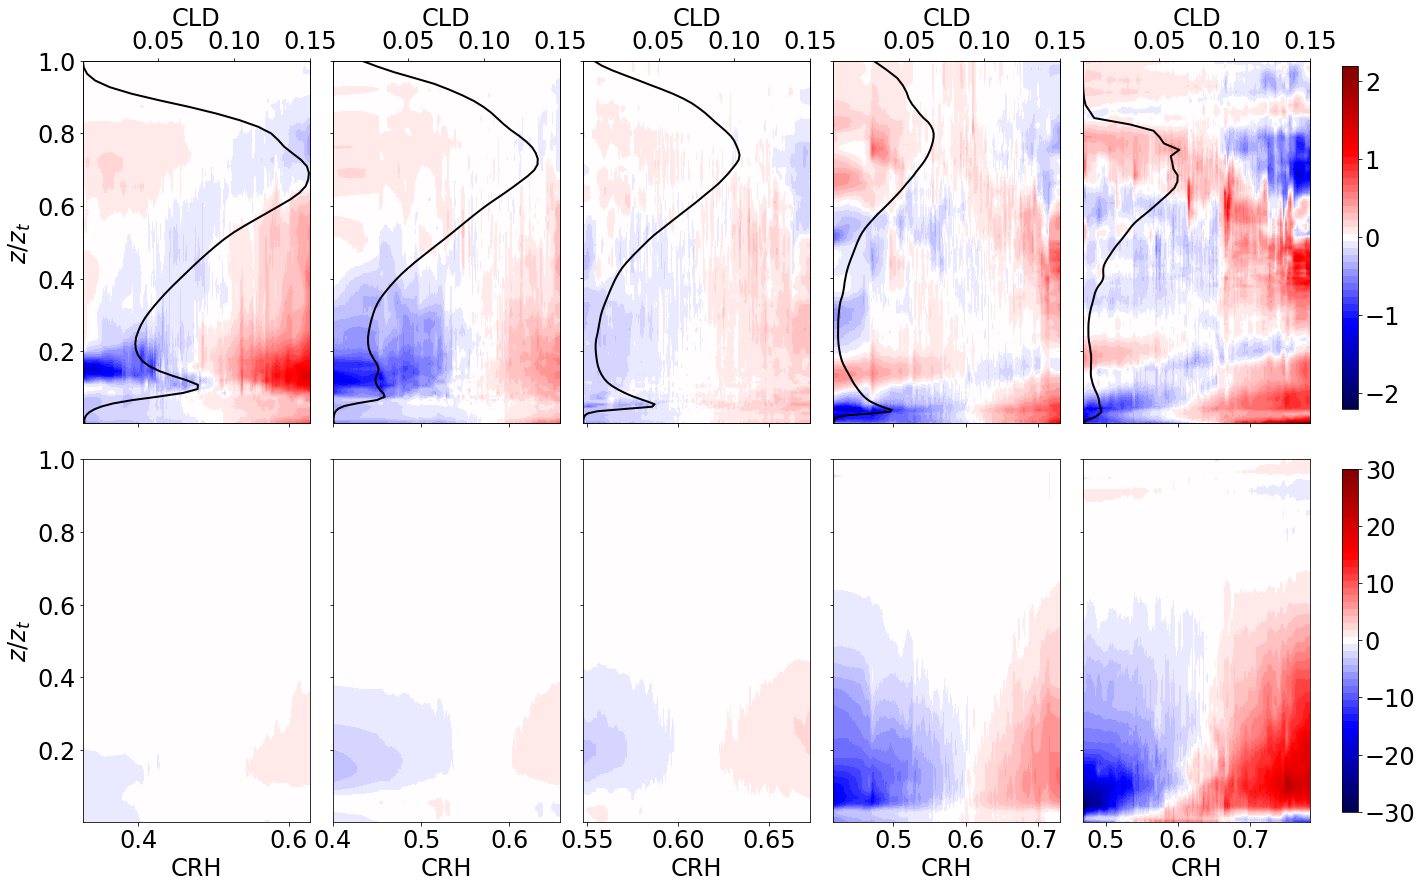

In [8]:
######## Figure 3 #################
# check if Q_rad' decreases with SSTs
# sort by CRH
# parameters
smooth_x = 11
smooth_t = 24*5
smx_bd = int((smooth_x - 1) / 2)

plt.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(22,14))
gs = fig.add_gridspec(2, 5, hspace=0.1, wspace=0.1)
ax = gs.subplots()

vmax1 = 0
vmax2 = 0

# select a time step
tstep = 10*24

for i,sst in enumerate(np.arange(280,330,10)):
    # choose the vertical level range
    fn1d = '/glade/scratch/linyao/SAMOUTPUT/csa2dLD'+str(sst)+'Kfine/dx2km8192x1xfiner/exe.sam/OUT_STAT/CSALD'+str(sst)+'Kfine_dx2km8192x1x128x3600_1dfile.nc'
    ds1 = xr.open_dataset(fn1d)

    T = ds1['TABS'][100*24:,:].mean('time').squeeze()
    itrop = int(T.argmin(dim='z') + 1)

    # z levels 
    z = ds1['z'][:itrop]

    # read smoothed Qrad'
    fnq = '/glade/scratch/linyao/SAMOUTPUT/TwoD/Qradp_sst'+str(sst)+'K_sgs_control_sx'+str(int(smooth_x*8))+'km_st'+str(int(smooth_t/24))+'d.nc'
    dsq = xr.open_dataset(fnq)
    Qradp = dsq['Q_RADp'][tstep,:itrop,:].squeeze() * 86400 / 1004
    
    # read smoothed h'
    fnh = '/glade/scratch/linyao/SAMOUTPUT/TwoD/hp_sst'+str(sst)+'K_sgs_control_sx'+str(int(smooth_x*8))+'km_st'+str(int(smooth_t/24))+'d.nc'
    dsh = xr.open_dataset(fnh)
    hp = dsh['hp'][tstep,:itrop,:].squeeze() / 1004

    # calculate CRH
    fnih = '/glade/scratch/linyao/SAMOUTPUT/csa2dLD'+str(sst)+'Kfine/dx2km8192x1xfiner/exe.sam/OUT_2D/CSALD'+str(sst)+'Kfine_dx2km8192x1x128x3600_2dfile.nc'
    dsih = xr.open_dataset(fnih)
    pw = dsih['PW'][:,::4]
    swvp = dsih['SWVP'][:,::4]
    mseip = pw / swvp
    
    cld = ds1['CLD'][tstep-int(smooth_t/2):tstep+int(smooth_t/2),:itrop].mean('time').squeeze()

    pw1 = mseip.rolling(time=smooth_t, min_periods=int(smooth_t/2), center=True).mean().dropna("time")  # smooth in time
    pw2 = xr.concat([pw1[:,-smx_bd:], pw1, pw1[:,:smx_bd]], dim="x")
    del mseip
    del pw1
    mseip = pw2.rolling(x=smooth_x, center=True).mean("x").dropna("x")  # smooth in x 
    del pw2
    
    crh = xr.DataArray(
        data=mseip.values,
        dims=["time","x"],
        coords=dict(
            time=dsih['time'],
            x = swvp.x,
        ),
    )
    
    flgsort = np.asarray(crh[tstep,:].values.argsort())

    x = crh[tstep,flgsort]
    y1 = Qradp[:,flgsort]
    
    y = xr.DataArray(
        data = y1.values,
        dims=['z','x'],
        coords=dict(
            z = z[:itrop].values/z[itrop-1].values,
            x = x.values,
        ),
    )
    
    # smooth among CRH
    y1 = y.rolling(x=20, center=True).mean("x").dropna("x")  # smooth in x 
    del y
    vmax1 = np.max([vmax1,y1.max(), -y1.min()])    
 

    im1 = ax[0,i].contourf(y1.x,y1.z,y1,cmap='seismic',levels=np.linspace(-2.2,2.2,50))
    ax[0,i].set_ylabel(r'$z/z_t$')
    
    axtmp = ax[0,i].twiny()
    axtmp.plot(cld,y1.z, linewidth=2, color='black')
    axtmp.set_xlabel('CLD')
    axtmp.set_xlim([0,0.15])
    axtmp.set_xticks([0.05, 0.1, 0.15])
    
    print(sst)
    print(vmax1)

    y2 = hp[:,flgsort]    
    
    y = xr.DataArray(
        data = y2.values,
        dims=['z','x'],
        coords=dict(
            z = z[:itrop].values/z[itrop-1].values,
            x = x.values,
        ),
    )
    
    # smooth among CRH
    y2 = y.rolling(x=20, center=True).mean("x").dropna("x")  # smooth in x 
    del y
    vmax2 = np.max([vmax2,y2.max(), -y2.min()])    
    
    im2 = ax[1,i].contourf(y2.x,y2.z,y2,cmap='seismic',levels=np.linspace(-30,30,50))
    ax[1,i].set_xlabel('CRH')
    ax[1,i].set_ylabel(r'$z/z_t$')
    plt.rcParams.update({'font.size': 24})
    
    print(vmax2)

tick = [-4, -2, -1,0,1,2,4]
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.535, 0.01, 0.34])
fig.colorbar(im1, cax=cbar_ax,ticks=tick)

tick = [-30, -20, -10,0,10,20,30]
cbar_ax = fig.add_axes([0.92, 0.135, 0.01, 0.34])
cbar = fig.colorbar(im2, cax=cbar_ax,ticks=tick) 

for axs in ax.flat:
    axs.label_outer()
    
# plt.savefig('hp_Qradp_CRH_sx'+str(int(smooth_x*8))+'km_st'+str(int(smooth_t/24))+'d_day'+str(int(tstep/24))+'.png', dpi=600, bbox_inches='tight')

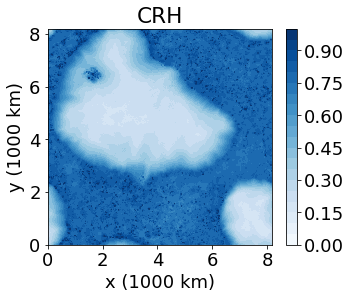

In [9]:
############ Figure 4 ##################
ds1 = xr.open_dataset('/glade/scratch/linyao/PW_320Khomorad.nc')
x = ds1.x 
y = ds1.y 
time_homorad = ds1.time 
a = ds1['PW']
del ds1
ds1 = xr.open_dataset('/glade/scratch/linyao/SWVP_320Khomorad.nc')
b = ds1['SWVP']
pw_homorad = a / b
# time_homorad
del a
del b
del ds1

ds1 = xr.open_dataset('/glade/scratch/linyao/PW_320K.nc')
time_control = ds1.time[:588] 
a = ds1.PW[:588,:,:]
del ds1
ds1 = xr.open_dataset('/glade/scratch/linyao/SWVP_320K.nc')
b = ds1.SWVP[:588,:,:]
pw_control = a / b 
# time_control

pwvar_control = pw_control.var(dim=["x", "y"])
pwvar_homorad = pw_homorad.var(dim=["x", "y"])

del a
del b
del ds1

plt.rcParams.update({'font.size': 18})
z = pw_homorad[-1,:,:].squeeze()
vmax = max(pw_homorad.max(), pw_control.max())

fig = plt.figure(figsize=(6.5,5))
ax = fig.add_axes([0.2, 0.2, 0.6, 0.6])
ln = plt.contourf(x/1e6,y/1e6, z, cmap='Blues', levels=np.arange(0,1.05,0.05))
plt.colorbar(ln, ax=ax)
ax.set_title('CRH')
ax.set_xlabel('x (1000 km)')
ax.set_ylabel('y (1000 km)')
ax.set_xticks([0, 2, 4, 6, 8])
ax.set_yticks([0, 2, 4, 6, 8])
# plt.savefig('CRH_homorad_day49.png', dpi=600, bbox_inches='tight')

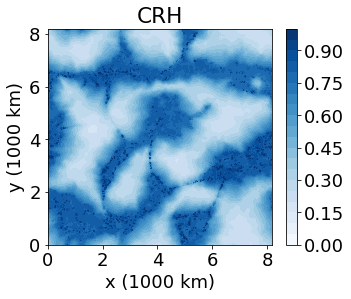

In [10]:
############ Figure 4 ##################
plt.rcParams.update({'font.size': 18})
z = pw_control[-1,:,:].squeeze()
vmax = max(pw_homorad.max(), pw_control.max())

fig = plt.figure(figsize=(6.5,5))
ax = fig.add_axes([0.2, 0.2, 0.6, 0.6])
ln = plt.contourf(x/1e6,y/1e6, z, cmap='Blues', levels=np.arange(0,1.05,0.05))
plt.colorbar(ln, ax=ax)
ax.set_title('CRH')
ax.set_xlabel('x (1000 km)')
ax.set_ylabel('y (1000 km)')
ax.set_xticks([0, 2, 4, 6, 8])

# plt.savefig('CRH_control_day49.png', dpi=600, bbox_inches='tight')

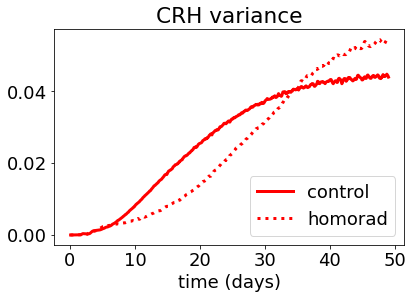

In [11]:
############ Figure 4 ##################
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8.1,5))
ax = fig.add_axes([0.2, 0.2, 0.6, 0.6])
ax.plot(time_control, pwvar_control, color='red', label='control',linewidth=3)
ax.plot(time_homorad, pwvar_homorad, color='red', linestyle='dotted', label='homorad',linewidth=3)
ax.set_xlabel('time (days)')
ax.set_title('CRH variance')
plt.legend(loc='lower right')

# plt.savefig('CRH_variance_3a.png', dpi=600, bbox_inches='tight')

In [12]:
############### Figure S1 ###############
def get_sgs_decomp(stad):
    sst_list = np.arange(280,330,10)
    smx_list = [5*8, 11*8, 15*8]  # smooth_x in km
    smt_list = [24, 72, 120, 240]  # smooth_t in hours [1, 3, 5, 10] days
    avlen_list = [5*24, 10*24, 15*24, 20*24, 25*24]
    nsst = len(sst_list)
    nsmx = len(smx_list)
    nsmt = len(smt_list)
    navl = len(avlen_list)

    # for each sst, get the averaged norm budget using different smooth_x, smooth_t and average length. 
    sgs0 = np.zeros((nsst, nsmx*nsmt*navl))
    sfc0 = np.zeros((nsst, nsmx*nsmt*navl))  
    res0 = np.zeros((nsst, nsmx*nsmt*navl))  
    # stad = 100

    # for each sst, get the mean and std of the averaged norm budget distribution
    sgs = np.zeros((nsst, 2))
    sfc = np.zeros((nsst, 2))
    res = np.zeros((nsst, 2))

    for i,sst in zip(np.arange(nsst), sst_list):
        ip0 = 0

        # calculate averaged T profile
        fn1d = '/glade/scratch/linyao/SAMOUTPUT/csa2dLD'+str(sst)+'Kfine/dx2km8192x1xfiner/exe.sam/OUT_STAT/CSALD'+str(sst)+'Kfine_dx2km8192x1x128x3600_1dfile.nc'
        ds = xr.open_dataset(fn1d)
        Teq = ds['TABS'][100*24:150*24,:].mean('time')

        # find the index of Tropopause
        itrop = Teq.argmin(dim="z").values + 1

        fn2d = '/glade/scratch/linyao/SAMOUTPUT/csa2dLD'+str(sst)+'Kfine/dx2km8192x1xfiner/exe.sam/OUT_2D/CSALD'+str(sst)+'Kfine_dx2km8192x1x128x3600_2dfile.nc'
        ds2 = xr.open_dataset(fn2d)
        sfc2d = ds2['SHF'][:,::4] + ds2['LHF'][:,::4]
        sfcp = sfc2d - sfc2d.mean('x')

        fn1d = '/glade/scratch/linyao/SAMOUTPUT/csa2dLD'+str(sst)+'Kfine/dx2km8192x1xfiner/exe.sam/OUT_STAT/CSALD'+str(sst)+'Kfine_dx2km8192x1x128x3600_1dfile.nc'
        ds1 = xr.open_dataset(fn1d)
        rho0 = ds1['RHO'][:,0].values

        fnd = '/glade/scratch/linyao/SAMOUTPUT/MSE_sst'+str(sst)+'K.nc'
        ds = xr.open_dataset(fnd)
        hf = ds['hf'][:,:2,:]

        hs = 2 * hf[:,0,:].values - hf[:,1,:].values
        hs = hs.squeeze()

        hs = xr.DataArray(
            data=hs,
            dims=['time','x'],
            coords=dict(
                time = sfcp.time,
                x = sfcp.x,
            ),
        )

        hsp = hs - hs.mean('x')

        del hf 
        del sfc2d

        for j,smx in zip(np.arange(nsmx), smx_list):
            for k,smt in zip(np.arange(nsmt), smt_list):
                smooth_x = smx
                smooth_t = smt
                smx_bd = int((smx-1)/2)

                fn = '~/CSA_rad/FMSE_budget_rho/FMSE_budget_1rho_sst'+str(sst)+'K_sgs_control_sx'+str(smx)+'km_st'+str(int(smt/24))+'d.nc'
                ds = xr.open_dataset(fn)
                local_var = ds['local_var']
                local_sgs = ds['local_sgs']

                z = ds['z']
                t = ds['time']

                dz = z[1:].values - z[0:-1].values

                int_var = np.sum(local_var[:,:itrop] * dz[None,:itrop], axis=1)
                int_sgs = np.sum(local_sgs[:,:itrop] * dz[None,:itrop], axis=1)

                sgs1  = int_sgs / int_var * 86400

                # smoothing 
                pw1 = hsp.rolling(time=smooth_t, min_periods=int(smooth_t/2), center=True).mean().dropna("time")  # smooth in time
                pw2 = xr.concat([pw1[:,-smx_bd:], pw1, pw1[:,:smx_bd]], dim="x")
                # del hsp
                del pw1
                hsp1 = pw2.rolling(x=smooth_x, center=True).mean("x").dropna("x")  # smooth in x 
                del pw2

                pw1 = sfcp.rolling(time=smooth_t, min_periods=int(smooth_t/2), center=True).mean().dropna("time")  # smooth in time
                pw2 = xr.concat([pw1[:,-smx_bd:], pw1, pw1[:,:smx_bd]], dim="x")
                # del sfcp
                del pw1
                sfcp1 = pw2.rolling(x=smooth_x, center=True).mean("x").dropna("x")  # smooth in x 
                del pw2

                tmp0 = sfcp1 * hsp1 * rho0[:,None]
                int_sfc = tmp0.mean('x')

                sfc1 = int_sfc / int_var * 86400

                res1 = sgs1 - sfc1

                for n,avl in zip(np.arange(navl), avlen_list):
                    sgs0[i,ip0] = np.mean(sgs1[stad*24:stad*24+avl*24])
                    sfc0[i,ip0] = np.mean(sfc1[stad*24:stad*24+avl*24])
                    res0[i,ip0] = np.mean(res1[stad*24:stad*24+avl*24])
                    ip0 = ip0 + 1 

        # the mean of the averaged norm budget
        sgs[i,0] = np.mean(sgs0[i,:])
        # the std of the averaged norm budget
        sgs[i,1] = np.std(sgs0[i,:])

        # the mean of the averaged norm budget
        sfc[i,0] = np.mean(sfc0[i,:])
        # the std of the averaged norm budget
        sfc[i,1] = np.std(sfc0[i,:])

        # the mean of the averaged norm budget
        res[i,0] = np.mean(res0[i,:])
        # the std of the averaged norm budget
        res[i,1] = np.std(res0[i,:])

    FMSEbudget = np.concatenate((sgs[:,0,None],sfc[:,0,None],res[:,0,None]), axis=1)
    FMSEbudget_std = np.concatenate((sgs[:,1,None], sfc[:,1,None], res[:,1,None]), axis=1)
    
    return FMSEbudget, FMSEbudget_std

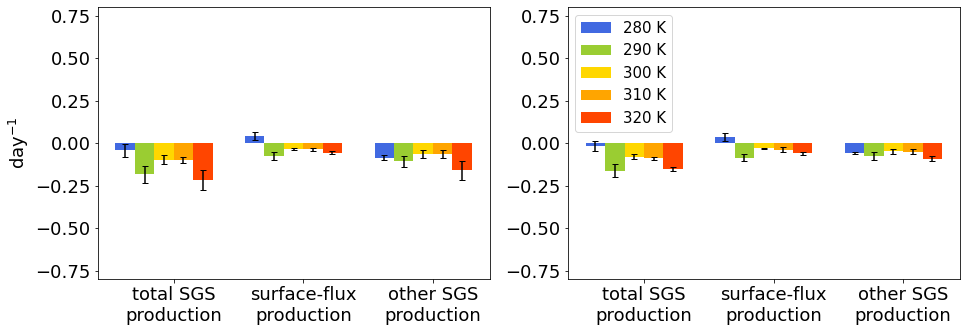

In [13]:
############### Figure S1 ###############
FMSEbudget1, FMSEbudget1_std = get_sgs_decomp(0)
FMSEbudget2, FMSEbudget2_std = get_sgs_decomp(100)

x = ["total SGS"+"\n"+"production", "surface-flux"+"\n"+"production", "other SGS"+"\n"+"production"]
x_axis = np.arange(len(x))
fig, ax = plt.subplots(1,2,figsize=(7.725*2,5))

plt.rcParams.update({'font.size': 18})
ax[0].bar(x_axis - 0.375, FMSEbudget1[0,:], yerr=FMSEbudget1_std[0,:], capsize=3, ecolor='black', width=0.15, label='280 K', color='royalblue')
ax[0].bar(x_axis - 0.225, FMSEbudget1[1,:], yerr=FMSEbudget1_std[1,:], capsize=3, ecolor='black', width=0.15, label='290 K', color='yellowgreen')
ax[0].bar(x_axis - 0.075, FMSEbudget1[2,:], yerr=FMSEbudget1_std[2,:], capsize=3, ecolor='black', width=0.15, label='300 K', color='gold')
ax[0].bar(x_axis + 0.075, FMSEbudget1[3,:], yerr=FMSEbudget1_std[3,:], capsize=3, ecolor='black', width=0.15, label='310 K', color='orange')
ax[0].bar(x_axis + 0.225, FMSEbudget1[4,:], yerr=FMSEbudget1_std[4,:], capsize=3, ecolor='black', width=0.15, label='320 K', color='orangered')

ax[0].set_xticks(x_axis, x)
ax[0].set_ylim([-0.8,0.8])
ax[0].set_ylabel("day" + r'$^{-1}$')

ax[1].bar(x_axis - 0.375, FMSEbudget2[0,:], yerr=FMSEbudget2_std[0,:], capsize=3, ecolor='black', width=0.15, label='280 K', color='royalblue')
ax[1].bar(x_axis - 0.225, FMSEbudget2[1,:], yerr=FMSEbudget2_std[1,:], capsize=3, ecolor='black', width=0.15, label='290 K', color='yellowgreen')
ax[1].bar(x_axis - 0.075, FMSEbudget2[2,:], yerr=FMSEbudget2_std[2,:], capsize=3, ecolor='black', width=0.15, label='300 K', color='gold')
ax[1].bar(x_axis + 0.075, FMSEbudget2[3,:], yerr=FMSEbudget2_std[3,:], capsize=3, ecolor='black', width=0.15, label='310 K', color='orange')
ax[1].bar(x_axis + 0.225, FMSEbudget2[4,:], yerr=FMSEbudget2_std[4,:], capsize=3, ecolor='black', width=0.15, label='320 K', color='orangered')

ax[1].set_xticks(x_axis, x)
ax[1].set_ylim([-0.8,0.8])
ax[1].legend(fontsize=15, loc='upper left')
# plt.savefig('Figure3bsgsexp.png', dpi=600, bbox_inches='tight')

922.3787518496749


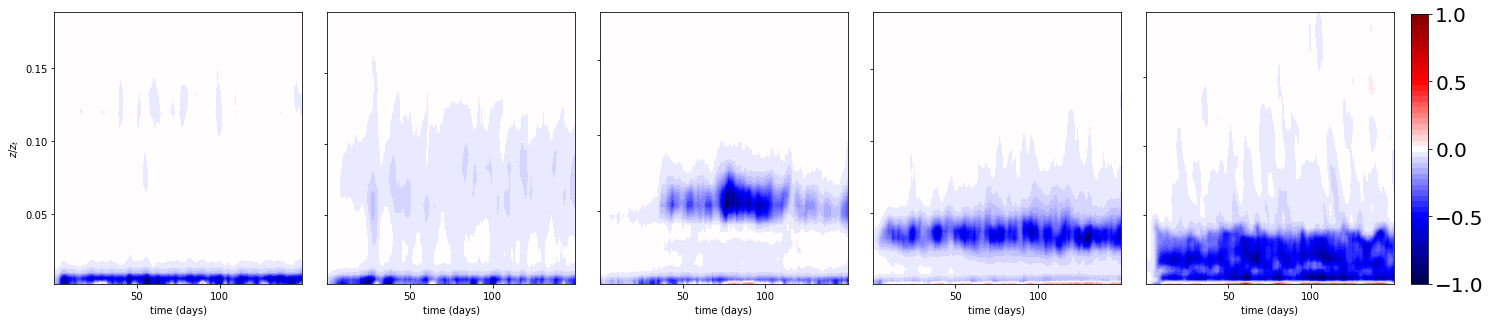

In [2]:
############### Figure S2 ###############
fn = '~/CSA_rad/SGS2.nc'  # run Get_SGSnc.py
ds = xr.open_dataset(fn)
sgs = ds['SGS2']
sgs2 = sgs.copy()

z = ds['z'].values

sst_list = np.arange(280,330,10)

vmax2 = np.max([sgs2.max(), -sgs2.min()]) 

cp = 1004
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(24,5))
gs = fig.add_gridspec(1, 5, wspace=0.1)
ax = gs.subplots()

for i,sst in enumerate(sst_list):
    fn = '/glade/scratch/linyao/SAMOUTPUT/csa2dLD'+str(sst)+'Kfine/dx2km8192x1xfiner/exe.sam/OUT_STAT/CSALD'+str(sst)+'Kfine_dx2km8192x1x128x3600_1dfile.nc'
    ds = xr.open_dataset(fn)
    T = ds['TABS'][100*24:,:].mean('time').squeeze()
    itrop = int(T.argmin(dim='z') + 1)

    xx = sgs2.time
    
    yy1 = z[:itrop] / z[itrop-1]
    
    itrop = np.argmin(np.asarray(np.absolute(yy1 - 0.2)))
    yy = yy1[:itrop]
    
    fn1 = '~/CSA_rad/FMSE_budget_rho/FMSE_budget_1rho_sst'+str(sst)+'K_sgs_control_sx88km_st5d.nc'
    ds1 = xr.open_dataset(fn1)
    local_var = ds1['local_var']

    z = ds1['z']
    t = ds1['time']

    dz = z[1:].values - z[0:-1].values

    int_var = np.sum(local_var[:,:itrop] * dz[None,:itrop], axis=1)
    
    zz = sgs2[i,:,:itrop] 
    
    vmax2 = np.max([zz.max(), -zz.min()]) 
    
    zz = zz / vmax2
    
    im2 = ax[i].contourf(xx,yy,zz.T,cmap='seismic',levels=np.linspace(-1,1,50))
    ax[i].set_xlabel('time (days)')
    plt.rcParams.update({'font.size': 20})
    
ax[0].set_ylabel(r'$z/z_t$')

print(vmax2)
tick = [-1,-0.5,0, 0.5,1]
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.125, 0.01, 0.75])
fig.colorbar(im2, cax=cbar_ax, ticks=tick)

for axs in ax.flat:
    axs.label_outer()
    
# plt.savefig('SGS_second_term.png',dpi=600,bbox_inches='tight')

In [3]:
############### Figure S3 ###############
# get the 2D simulations' PW plots
sst_list = np.arange(315,325,10)
pw_control = []
pw_homorad = []

for i, sst in enumerate(sst_list):
    fn2d = '/glade/scratch/linyao/SAMOUTPUT/csaLD'+str(sst)+'Kfine/dx2km8192x1xfiner/exe.sam/OUT_2D/CSALD'+str(sst)+'Kfine_dx2km8192x1x128x3600_2dfile.nc'
    ds = xr.open_dataset(fn2d)
    tmp = ds['PW'][:, 0::8] / ds['SWVP'][:, 0::8]
    pw_control.append(tmp)
    del ds 
    fn2d = '/glade/scratch/linyao/SAMOUTPUT/csaLD'+str(sst)+'KHOMORAD/LDhomoradCL/exe.sam/OUT_2D/CSALD'+str(sst)+'KfineHomoRCL_2dfile.nc'
    ds = xr.open_dataset(fn2d)
    tmp = ds['PW'][:, 0::8] / ds['SWVP'][:, 0::8]
    pw_homorad.append(tmp)
    
t = ds['time']
x = ds['x'][0::8] / 1e6   
del ds

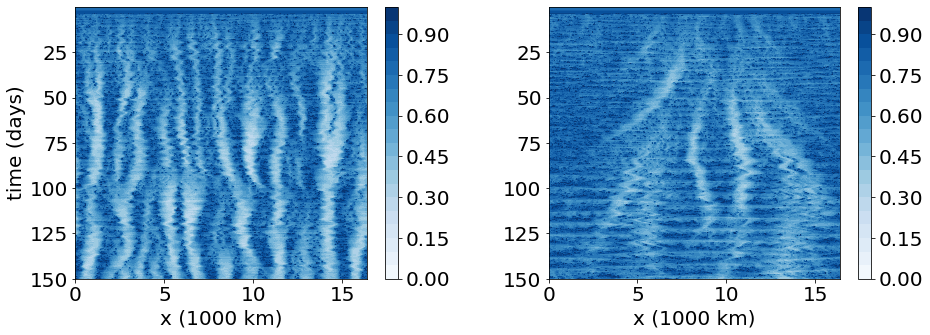

In [4]:
############### Figure S3 ###############
# draw the plots for control simulations
# fig, axs = plt.subplots(2, 5, figsize=(17,10))
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1, 2, wspace=0.3)
axs = gs.subplots()
plt.rcParams.update({'font.size': 20})

for i, sst in enumerate(sst_list):
    plt.rcParams.update({'font.size': 20})
    levels = np.arange(0,1.05,0.05)
    plt.rcParams.update({'font.size': 20})
    im1 = axs[0].contourf(x, t, pw_control[i], cmap='Blues', levels=levels)
    axs[0].invert_yaxis()
    plt.colorbar(im1, ax=axs[0])
    
    im2 = axs[1].contourf(x, t, pw_homorad[i], cmap='Blues', levels=levels)
    axs[1].invert_yaxis()
    plt.rcParams.update({'font.size': 20})
    plt.colorbar(im2, ax=axs[1])
    
    axs[0].set(xlabel='x (1000 km)', ylabel='time (days)')
    axs[0].set_xticks([0,5,10,15])
    axs[1].set(xlabel='x (1000 km)')
    axs[1].set_xticks([0,5,10,15])

# plt.savefig('FigureS3_CRH.png',dpi=600, bbox_inches='tight')